# Sensor Projection

In this tutorial, we will demonstrate how to define a **sensor geometry** and project its trace onto the **Earth**.

## Setup

Let's import the necessary dependencies:

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go

from ostk.mathematics.geometry.d2 import Object as Object2d
from ostk.mathematics.geometry.d2.object import Point as Point2d
from ostk.mathematics.geometry.d2.object import Polygon as Polygon2d
from ostk.mathematics.geometry.d3.object import Point as Point3d
from ostk.mathematics.geometry.d3.object import Polygon as Polygon3d
from ostk.mathematics.geometry.d3.object import Pyramid

from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate import Frame
from ostk.physics import Environment
from ostk.physics.environment.object import Geometry

---

## Computation

### Scene

We first set up a simple scene, with the Earth only (the default `Environment` will suffice here):

In [2]:
environment = Environment.default();

Then, we access the `Earth` object (managed by the `Environment`):

In [3]:
earth = environment.access_object_with_name("Earth")

Once the `Earth` has been obtained, we can also get its geometry (an `Ellipsoid`, defined in `ITRF` in this case):

In [4]:
earth_geometry = earth.get_geometry_in(Frame.ITRF(), environment.get_instant())

### Sensor

Let's define a pyramidal geometry:

In [5]:
apex = Point3d(7000e3, 0.0, 0.0)
base = Polygon3d(
    Polygon2d(
        [
            Point2d(-1.0, -1.0),
            Point2d(+1.0, -1.0),
            Point2d(+1.0, +1.0),
            Point2d(-1.0, +1.0),
        ]
    ),
    apex - np.array((0.8, 0.0, 0.0)),
    np.array((0.0, 1.0, 0.0)),
    np.array((0.0, 0.0, 1.0)),
)

pyramid = Pyramid(base, apex)

That we express in `ITRF`:

In [6]:
sensor_geometry = Geometry(pyramid, Frame.ITRF())

### Intersection

Now that we have both Earth and sensor geometries clearly defined, we can compute their intersection:

In [7]:
intersection_ITRF = sensor_geometry.intersection_with(earth_geometry)

And convert this 3D intersection into a 2D set of geodetic points:

In [8]:
intersection_points = [
    Point2d(lla.get_longitude().in_degrees(), lla.get_latitude().in_degrees())
    for lla in [
        LLA.cartesian(
            point_ITRF.as_vector(),
            earth.get_equatorial_radius(),
            earth.get_flattening(),
        )
        for point_ITRF in intersection_ITRF.access_composite()
        .access_object_at(0)
        .as_line_string()
    ]
]

We further convert this set into a Pandas Dataframe, as a very convenient way for storing / managing data in Python:

In [9]:
intersection_df = pd.DataFrame(
    [
        [float(intersection_point.x()), float(intersection_point.y())]
        for intersection_point in intersection_points
    ],
    columns=["Longitude", "Latitude"],
);

---

## Visualization

Table:

In [10]:
intersection_df.head()

,Longitude,Latitude
0,-8.768110,-8.724722
1,-8.152081,-5.915811
2,-7.861134,-3.893096
3,-7.713082,-2.226165
4,-7.649110,-0.725557


Now, we're ready to visualize the intersection on a map!

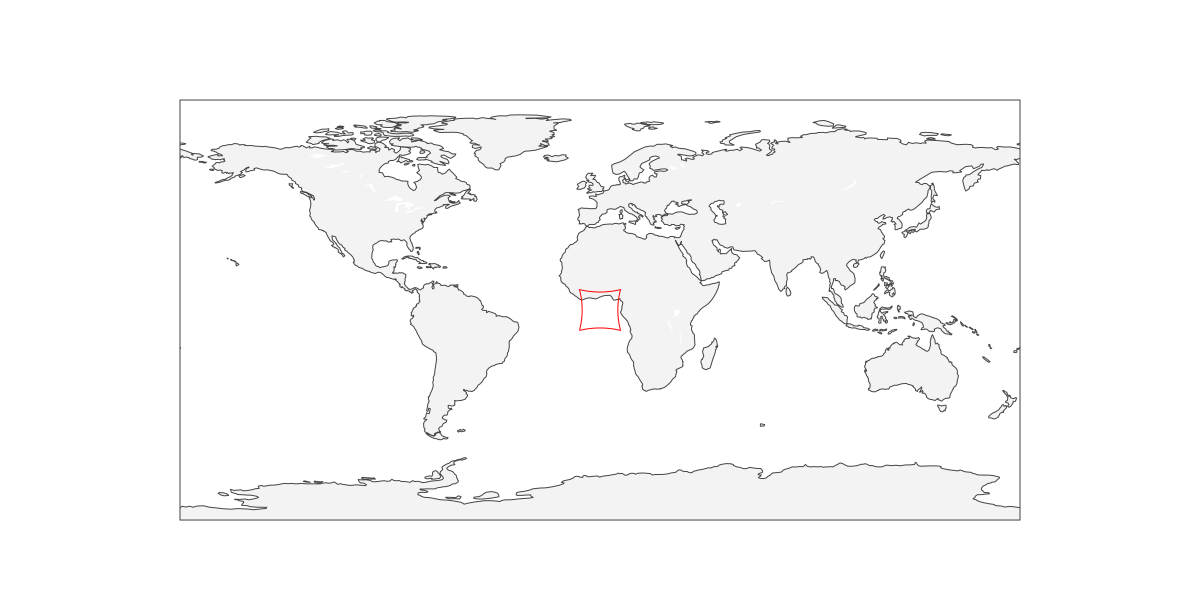

In [11]:
figure = go.Figure(
    data=go.Scattergeo(
        lon=intersection_df["Longitude"],
        lat=intersection_df["Latitude"],
        mode="lines",
        line=dict(
            width=1,
            color="red",
        ),
    ),
    layout=go.Layout(
        title=None,
        showlegend=False,
        geo=dict(
            showland=True,
            landcolor="rgb(243, 243, 243)",
            countrycolor="rgb(204, 204, 204)",
        ),
        height=600,
        width=1200,
    ),
)

figure.show("svg")

It is also possible to obtain the `WKT` representation of the intersection polygon:

In [12]:
Polygon2d(intersection_points).to_string(Object2d.Format.WKT)

POLYGON((-8.76811 -8.72472,-8.15208 -5.91581,-7.86113 -3.8931,-7.71308 -2.22617,-7.64911 -0.725557,-7.64911 0.725557,-7.71308 2.22617,-7.86113 3.8931,-8.15208 5.91581,-8.76811 8.72472,-8.76811 8.72472,-5.93863 8.16636,-3.90611 7.90015,-2.23303 7.76406,-0.727714 7.70513,0.727714 7.70513,2.23303 7.76406,3.90611 7.90015,5.93863 8.16636,8.76811 8.72472,8.76811 8.72472,8.15208 5.91581,7.86113 3.8931,7.71308 2.22617,7.64911 0.725557,7.64911 -0.725557,7.71308 -2.22617,7.86113 -3.8931,8.15208 -5.91581,8.76811 -8.72472,8.76811 -8.72472,5.93863 -8.16636,3.90611 -7.90015,2.23303 -7.76406,0.727714 -7.70513,-0.727714 -7.70513,-2.23303 -7.76406,-3.90611 -7.90015,-5.93863 -8.16636,-8.76811 -8.72472,-8.76811 -8.72472))

---